Deep Learning Model to Predict Comsumption

Build deep learning model to predict consumption using TensorFlow (keras)

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
# import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
# import tensorflow_transform as tft
print(tf.__version__)

2.0.0-beta1


In [2]:
FILE = 'recs2009_public.csv'
df= pd.read_csv(FILE)
df_dummies =  pd.get_dummies(df)
# X and y for supervised learning
X = df_dummies.drop(['KWH'],axis = 1)
y = df_dummies['KWH']

/usr/common/software/tensorflow/gpu-tensorflow/2.0.0-beta-py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (717,718) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Split train and test data
from sklearn.model_selection import train_test_split
X_train_pre, X_test_pre, y_train, y_test = train_test_split(X, y)

In [4]:
# Preprocessing & Normalization
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_pre)
# Train and Test data before feature selection
X_train_prefs = scaler.transform(X_train_pre)
X_test_prefs = scaler.transform(X_test_pre)

In [20]:
#Assign train and test data
X_train = X_train_prefs
X_test = X_test_prefs
N  = len(X_train)
print(N)

9062


In [21]:
def build_model():
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_dim=X_train.shape[1]),
        layers.Dense(64, activation='relu',activity_regularizer = 'l2'),
        layers.Dense(32, activation='relu',activity_regularizer = 'l2'),
        layers.Dense(1)])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(optimizer=optimizer,
              loss='mse',
              metrics=['mae', 'mse'])
    return model

In [22]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print('.', end='')

In [23]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [KWH]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
#   plt.ylim([0,5])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$KWH^2$]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
#   plt.ylim([0,20])
    plt.legend()
    plt.show()

In [24]:
model = build_model()

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               128128    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 138,497
Trainable params: 138,497
Non-trainable params: 0
_________________________________________________________________


In [26]:
EPOCHS = 1000

history = model.fit(X_train, y_train, epochs=EPOCHS,
                    validation_split = 0.2,
                    verbose=0,callbacks=[PrintDot()])


..........

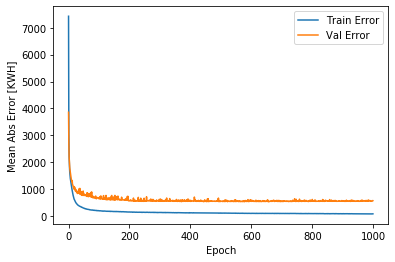

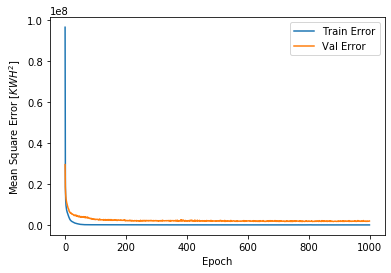

In [27]:
plot_history(history)

In [28]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,43806.427342,77.361298,27022.474609,1.794151e+06,548.181091,1778407.250,995
996,38983.373941,79.614578,22215.207031,1.861781e+06,556.264771,1846021.750,996
997,35572.799979,78.071983,18837.332031,1.803308e+06,554.648438,1787763.000,997
998,34114.263315,78.944687,17453.228516,1.793559e+06,555.702454,1777815.500,998
999,34396.673671,80.205833,17786.267578,1.934041e+06,568.946716,1918717.625,999


In [29]:
loss, mae, mse = model.evaluate(X_test, y_test, verbose=0)
print("Testing set Mean Abs Error: {:5.2f} KWH".format(mae))

Testing set Mean Abs Error: 570.01 KWH


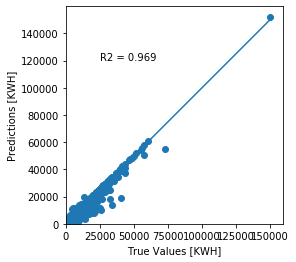

In [30]:
test_predictions = model.predict(X_test).flatten()
from sklearn.metrics import r2_score
r2 = r2_score(y_test, test_predictions)

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [KWH]')
plt.ylabel('Predictions [KWH]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.text(25000,120000,'R2 = {:3.3f}'.format(r2))
_ = plt.plot([0, 150000], [0, 150000])

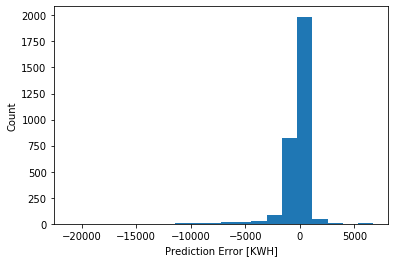

In [31]:
error = test_predictions - y_test
plt.hist(error, bins = 20)
plt.xlabel("Prediction Error [KWH]")
_ = plt.ylabel("Count")